## 0. Imports

In [111]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from implementations import * 
from proj1_helpers import *
from helpers import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data

In [112]:
# just load the train data set
data_path = "../dataset/train.csv"
y, x_raw, col_labels = load_partial_csv_data(data_path, 10000)
y,x_raw = equalize_predictions(y,x_raw)

_,data_u,ids_u = load_csv_data("../dataset/test.csv")

y.shape, x_raw.shape

((6744,), (6744, 30))

## 2. fill with nan values where there are invalid entries 

In [113]:
# example
k = np.array([
    [1,     0, -999],
    [7,     2,   -5],
    [-7,    0,    5],
    [-999, -1,    5],
    [-7,    2, -999]
])

print(k)
print()

# fill
nan_values = [-999, 0]
k = fill_with_nan_list(k, nan_values)
print(k)
print()

# ->>>> NB: probably better to substitute after standardization at step 5 <<<<-

# generate meaningful values with: 
# - np.nanmean(x, axis=0) (mean of each colum without considering nan values)
# - np.nanmedian(x, axis=0) (mean of each colum without considering nan values)
# - np.nanstd(x, axis=0) (mean of each colum without considering nan values)
k = sustitute_nans(k, substitutions=[-100, -200, -300]) 
# e.g. x = sustitute_nans(x, substitutions=np.nanmean(x, axis=0)) 
print(k)

[[   1    0 -999]
 [   7    2   -5]
 [  -7    0    5]
 [-999   -1    5]
 [  -7    2 -999]]

[[  1.  nan  nan]
 [  7.   2.  -5.]
 [ -7.  nan   5.]
 [ nan  -1.   5.]
 [ -7.   2.  nan]]

[[   1. -200. -300.]
 [   7.    2.   -5.]
 [  -7. -200.    5.]
 [-100.   -1.    5.]
 [  -7.    2. -300.]]


In [114]:
x = fill_with_nan_list(x_raw, nan_values=[0, -999])
x.shape

(6744, 30)

## 3. standardize (it won't consider the np.nan entries)

In [115]:
x, mean_x, std_x = standardize(x)
x.shape

(6744, 30)

## 4. either drop_nan_rows/column or substitute nan values with something meaningful

In [116]:
# check drop_nan_rows/columns and sustitute_nans in implementations.py
# np.nanmean(x, axis=0) should be an array of 0s (the column are standardized)
x = sustitute_nans(x, substitutions=np.nanmean(x, axis=0)) 
x.shape

(6744, 30)

## 5. train and test models:

### Ridge regression with cross validation

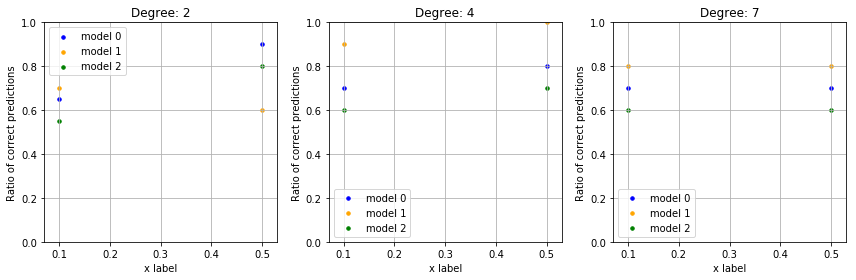

In [117]:
# just show how the function ratios_visualization works

model1 = np.array([
    [0.65, 0.9], # relative to degrees[0]
    [0.7, 0.8],  # relative to degrees[1]
    [0.7, 0.7]]) # relative to degrees[2]
model2 =  np.array([
    [0.7, 0.6],  # relative to degrees[0]
    [0.9, 1],    # relative to degrees[1]
    [0.8, 0.8]]) # relative to degrees[2]
degree_list = np.array([2, 4, 7])
lambdas = np.array([0.1, 0.5]) # x asis
 
ratios_visualization([model1, model2, model1-0.1], degree_list, lambdas, x_label="x label", log_axis_x=False, 
                     save_figure_with_name="test_figure")

In [118]:
# the lambda of the ridge regression does not affect much the model
nlambdas = 3
lambdas = np.linspace(0, 1000, nlambdas)

num_K_sets = 5
degree_list = [2, 3, 4]

ratio_tr, ratio_te = cross_validation_ridge_regression(x, y, num_K_sets, degree_list, lambdas)

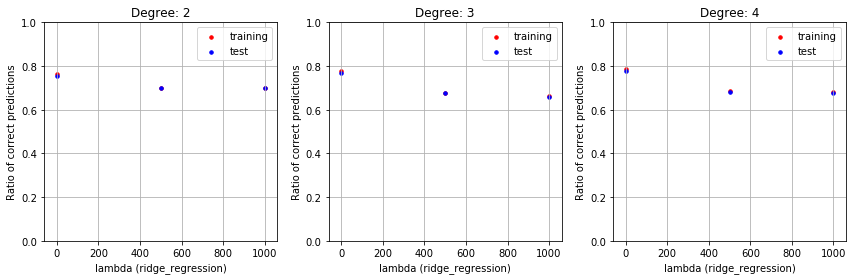

[    0.   500.  1000.]


((3, 3), (3, 3))

In [119]:
# there is A LOT of data => there is no overfitting => the training error is close to the test error => it does
# not makes sense to do the cross validation (just use the whole set to train the data and compute the 
# SUCCESS_RATIO on the training data)
cross_validation_visualization(ratio_tr, ratio_te, degree_list, lambdas, "lambda (ridge_regression)")

print(lambdas)
ratio_tr.shape, ratio_te.shape

### Ridge regression without cross validation

In [120]:
# the lambda of the ridge regression does not affect mush the model
nlambdas = 3
lambdas = np.linspace(0, 1000, nlambdas)
degree_list = [2, 3, 4]

ratios = ridge_regression_tuning(x, y, degree_list, lambdas)

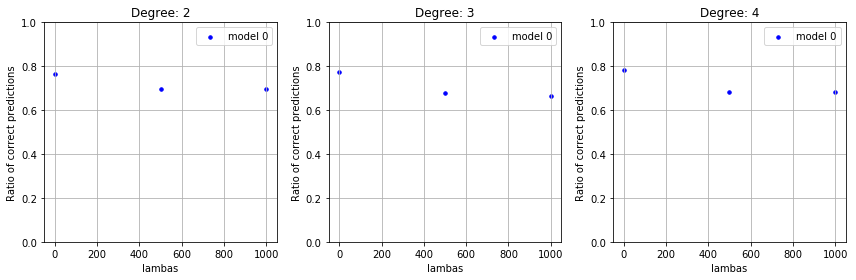

[    0.   500.  1000.]


In [121]:
x_axis = lambdas
figure_name = "ridge regression,nan_values=[0, -999],substitutions=nanmean(x, axis=0)"
ratios_visualization([ratios], degree_list, x_axis, x_label="lambas", log_axis_x=False,
                    save_figure_with_name=figure_name)

print(lambdas)

### Gradient descent try

In [122]:
degree = 4
tx = build_poly(x, degree) 
initial_w = np.zeros(len(y))
max_iters = 20
gamma = 0.5
#loss, w = gradient_descent(y, tx, initial_w, max_iters, gamma, batch_size=1)
#loss,w

### Logistic regression

Gradient Descent(0/4): loss=68761637709.58899, weights=[-0.99999998794891809, -1.0000000078055982, -0.99999986492651938]
Gradient Descent(1/4): loss=42056586463.22049, weights=[-0.99999997841652688, -1.0000000136410503, -0.99999975921858975]
Gradient Descent(2/4): loss=25723426394.119267, weights=[-0.99999997085389536, -1.0000000179357362, -0.99999967647619459]
Gradient Descent(3/4): loss=15733851185.246788, weights=[-0.99999996483172837, -1.0000000210254556, -0.9999996116941563]
Gradient Descent(4/4): loss=9624095788.514553, weights=[-0.99999996001429248, -1.000000023172823, -0.99999956095814069]
0.5


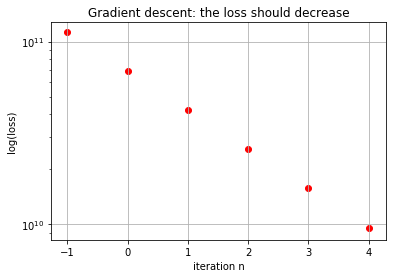

In [123]:
initial_w = np.zeros(tx.shape[1])-1
max_iters = 5 # try a small one first to check it is converging 
gamma = 0.000000000002 # very small (for higher diverges)

_, w = gradient_descent(y, tx, initial_w, max_iters, gamma, batch_size=-1, 
                        print_output_with_weights=[0, 1, 2], plot_losses=True, costfunc=CostFunction.MSE)

print(compute_loss(y, tx, w, costfunc=CostFunction.SUCCESS_RATIO))

### Exportation

In [128]:

loss, w = ridge_regression(y, tx, 0.001)

test_model_and_export(data_u,ids_u,w,degree)



(568238, 2)
['Id', 'Prediction']
